![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Data ingestion and validation

... testing for data.

We now can load data. Thats nice - but how do we verify that we get what we expect. Does this batch of data differ from previous sensor measurements for instance? Is there something broken? Any drifts in the data?

Normally, this would lead to some really messy code where we'd build huge piles of `if else` blocks to make sure that the data is in an expected range etc.

A much nicer tool to encode our **expectations** on the data is with `great_expectations`.

This great package allows you to write down your expectations on the data and export it into an expectations file. When new data arrives or data changes you can validate this new data against those expectations.

This is very useful if you have a data pipeline or stream data into your precessing...



In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import great_expectations as ge
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

For toying around, we first start with a very famous dataset. The titanic passenger survival data. It's included with great expectations but we pull it fcrom their github first.

In [1]:
! wget https://raw.githubusercontent.com/great-expectations/great_expectations/develop/examples/data/Titanic.csv

--2019-09-03 20:01:07--  https://raw.githubusercontent.com/great-expectations/great_expectations/develop/examples/data/Titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70366 (69K) [text/plain]
Saving to: ‘Titanic.csv’

Titanic.csv         100%[===================>]  68.72K  --.-KB/s    in 0.02s   

2019-09-03 20:01:08 (2.87 MB/s) - ‘Titanic.csv’ saved [70366/70366]



Next, we read it with `read_csv`. However, instead of the plain pandas read_csv, we use the version from `great_expectations`. It works the same...

In [4]:
titanic_df = ge.read_csv("Titanic.csv")

In [5]:
titanic_df.head()

,Unnamed: 0,Name,PClass,Age,Sex,Survived,SexCode
0,1,"Allen, Miss Elisabeth Walton",1st,29.00,female,1,1
1,2,"Allison, Miss Helen Loraine",1st,2.00,female,0,1
2,3,"Allison, Mr Hudson Joshua Creighton",1st,30.00,male,0,0
3,4,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)",1st,25.00,female,0,1
4,5,"Allison, Master Hudson Trevor",1st,0.92,male,1,0


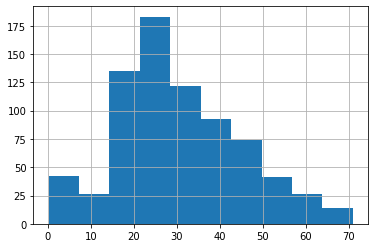

In [6]:
titanic_df.Age.hist();

Let's define our frist expectation: The column mean of column Age should be between 20 and 40. The response is a True (it's valid) - and we get some extra stats as a JSON response.

In [7]:
titanic_df.expect_column_mean_to_be_between("Age", 20,40)

{'success': True,
 'result': {'observed_value': 30.397989417989415,
  'element_count': 1313,
  'missing_count': 557,
  'missing_percent': 0.4242193450114242}}

Let's do another one. Age should range between 0 and 80.

In [8]:
titanic_df.expect_column_values_to_be_between("Age", 0,80)

{'success': True,
 'result': {'element_count': 1313,
  'missing_count': 557,
  'missing_percent': 0.4242193450114242,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

Now something more difficult: The name column should match this complicated RegEx. If you don't know what regexes are - don't worry. It's a complicated way to parse text in very little letters of code 😁... What is interesting this line ist the last argument. We specify that 95% of all data should fulfill this expectation.

In [9]:
titanic_df.expect_column_values_to_match_regex('Name', '[A-Z][a-z]+(?: \([A-Z][a-z]+\))?, ', mostly=.95)

{'success': True,
 'result': {'element_count': 1313,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 3,
  'unexpected_percent': 0.002284843869002285,
  'unexpected_percent_nonmissing': 0.002284843869002285,
  'partial_unexpected_list': ['Downton (?Douton), Mr William James',
   'Jacobsohn Mr Samuel',
   'Seman Master Betros']}}

Now some more: The entries for feature column "sex" sould either be "male" or "female". These are the two instances of the allowed set().

In [37]:
titanic_df.expect_column_values_to_be_in_set('Sex', ['male', 'female'])

{'success': True,
 'result': {'element_count': 1313,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

Feature "survived" shold be a boolean - thus only 1 and 0 is allowed.

In [38]:
titanic_df.expect_column_values_to_be_in_set('Survived', [1, 0])

{'success': True,
 'result': {'element_count': 1313,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

No test if PClass values are wither 1st, 2nd or 3rd.

In [39]:
titanic_df.expect_column_values_to_be_in_set('PClass', ['1st', '2nd', '3rd'])

{'success': False,
 'result': {'element_count': 1313,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 1,
  'unexpected_percent': 0.0007616146230007616,
  'unexpected_percent_nonmissing': 0.0007616146230007616,
  'partial_unexpected_list': ['*']}}

Hm. This fails. And this is due to a '*' in the data. Since it failed, this expectation is not recorded. We can have a look at all recorded expectations:

In [11]:
print(json.dumps(titanic_df.get_expectation_suite(), indent=2))

{
  "data_asset_name": null,
  "expectation_suite_name": "default",
  "meta": {
    "great_expectations.__version__": "0.7.7"
  },
  "expectations": [
    {
      "expectation_type": "expect_column_mean_to_be_between",
      "kwargs": {
        "column": "Age",
        "min_value": 20,
        "max_value": 40
      }
    },
    {
      "expectation_type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "Age",
        "min_value": 0,
        "max_value": 80
      }
    },
    {
      "expectation_type": "expect_column_values_to_match_regex",
      "kwargs": {
        "column": "Name",
        "regex": "[A-Z][a-z]+(?: \\([A-Z][a-z]+\\))?, ",
        "mostly": 0.95
      }
    }
  ],
  "data_asset_type": "Dataset"
}


Now we could dump this expectation config to disk and validate any new data coming in if it fulfills these expectations:

In [13]:
# titanic_df.save_expectation_suite('titanic_expectations.json')

## Build expectations for a sensor dataset from a TERENO site: TODO is we have time